# Data exploration

Dit notebook zal worden gebruikt voor het vinden van interessante features.

In [2]:
# imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Kolommen die niet met n.v.t. of "?" werden aangegeven in de data dictionary.
# Zulke kolommen mochten wij negeren (volgens het interview)
cols_to_use= [
 '#stm_sap_meldnr',
 'stm_mon_nr',
 'stm_vl_post',
 'stm_sap_meld_ddt',
 'stm_sap_meldtekst_lang',
 'stm_sap_meldtekst',
 'stm_geo_mld',
 'stm_geo_mld_uit_functiepl',
 'stm_equipm_nr_mld',
 'stm_equipm_soort_mld',
 'stm_equipm_omschr_mld',
 'stm_km_van_mld',
 'stm_km_tot_mld',
 'stm_prioriteit',
 'stm_status_melding_sap',
 'stm_aanngeb_ddt',
 'stm_oh_pg_gst',
 'stm_geo_gst',
 'stm_geo_gst_uit_functiepl',
 'stm_equipm_nr_gst',
 'stm_equipm_soort_gst',
 'stm_equipm_omschr_gst',
 'stm_km_van_gst',
 'stm_km_tot_gst',
 'stm_oorz_groep',
 'stm_oorz_code',
 'stm_oorz_tkst',
 'stm_fh_ddt',
 'stm_fh_status',
 'stm_sap_storeind_ddt',
 'stm_tao_indicator',
 'stm_tao_indicator_vorige',
 'stm_tao_soort_mutatie',
 'stm_tao_telling_mutatie',
 'stm_tao_beinvloedbaar_indicator',
 'stm_evb',
 'stm_sap_melddatum',
 'stm_sap_meldtijd',
 'stm_contractgeb_mld',
 'stm_functiepl_mld',
 'stm_techn_mld',
 'stm_contractgeb_gst',
 'stm_functiepl_gst',
 'stm_techn_gst',
 'stm_aanngeb_dd',
 'stm_aanngeb_tijd',
 'stm_aanntpl_dd',
 'stm_aanntpl_tijd',
 'stm_arbeid',
 'stm_progfh_in_datum',
 'stm_progfh_in_tijd',
 'stm_progfh_in_invoer_dat',
 'stm_progfh_in_invoer_tijd',
 'stm_progfh_in_duur',
 'stm_progfh_gw_tijd',
 'stm_progfh_gw_lwd_datum',
 'stm_progfh_gw_lwd_tijd',
 'stm_progfh_gw_duur',
 'stm_progfh_gw_teller',
 'stm_afspr_aanvangdd',
 'stm_afspr_aanvangtijd',
 'stm_fh_dd',
 'stm_fh_tijd',
 'stm_fh_duur',
 'stm_reactie_duur',
 'stm_sap_storeinddatum',
 'stm_sap_storeindtijd',
 'stm_oorz_tekst_kort',
 'stm_pplg_van',
 'stm_pplg_naar',
 'stm_dstrglp_van',
 'stm_dstrglp_naar']

In [4]:
df = pd.read_csv("data/sap_storing_data_hu_project.csv", index_col=0, usecols=cols_to_use, engine='pyarrow')
df.sample(20)
len(df)

898526

## Target variabele aanmaken

Target variabele anm_tot_fh, welke de duur vanaf dat de aannemer ter plaatse is, tot het daadwerkelijke functieherstel.

In [4]:
# Convert columns to datetime type
df['stm_aanntpl_tijd'] = pd.to_datetime(df['stm_aanntpl_tijd'], format='%H:%M:%S', errors='coerce')
df['stm_aanntpl_dd'] = pd.to_datetime(df['stm_aanntpl_dd'], format='%d/%m/%Y', errors='coerce')
df['stm_fh_ddt'] = pd.to_datetime(df['stm_fh_ddt'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Combine date and time columns to a datetime column
df['stm_aanntpl_tijd'] = df['stm_aanntpl_tijd'].astype('str')
df['stm_aanntpl_dd'] = df['stm_aanntpl_dd'].astype('str')
df["aanntpl_ddt"] = df["stm_aanntpl_dd"] + " " + df["stm_aanntpl_tijd"].apply(lambda x: x.split(' ')[-1])
df['aanntpl_ddt'] = pd.to_datetime(df['aanntpl_ddt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df = df.dropna(subset=['aanntpl_ddt'])
len(df)

689915

In [5]:
# Maak een kolom met de duur van de aannemer ter plaatse tot functieherstel
df['anm_tot_fh'] = df['stm_fh_ddt'] - df['aanntpl_ddt']
df['anm_tot_fh'] = df['anm_tot_fh'].apply(lambda x: x.seconds/60 + x.days * (24*60))
df = df.dropna(subset=['anm_tot_fh'])
len(df)

683985

We halen negatieve waardes voor de targetvariabele uit de dataset. \
Deze zijn voor ons model, wat de functiehersteltijd wilt berekenen als de aannemer
ter plaatse is gekomen niet relevant. Het probleem is dan namelijk al opgelost. \
\
Verder is ons verteld dat wij storingen met een verwachte functieherstelduur van korter
dan 5 minuten of langer dan 8 uur mogen weglaten. \ 
Deze storingen zijn óf zodanig snel opgelost dat deze niet nuttig zijn om een voorspelling voor te doen, \
óf zodanig lang, dat het treinverkeer toch niet snel zal rijden, en het beter is om af te wachten.

In [6]:
# We halen negatieve waardes voor de targetvariabele uit de data
df = df[df['anm_tot_fh'] >= 0]
# We halen prognoses voor korter dan 5 minuten en langer dan 8 uur uit de data
df = df[(df['anm_tot_fh'] >= 5) & (df['anm_tot_fh'] <= 480)]

In [7]:
def remove_outlier(df_in, col_name, k=3):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 
    fence_low  = q1 - k * iqr
    fence_high = q3 + k * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

## Data exploration

### stm_progfh_in_duur

In [8]:
# Remove nonsense values
dfprog = df
dfprog['stm_progfh_in_duur'] = df['stm_progfh_in_duur'].str.extract('(\d+)', expand=False)
dfprog['stm_progfh_in_duur'] = dfprog['stm_progfh_in_duur'].astype('int32')
dfprog = dfprog[dfprog.stm_progfh_in_duur != 99999999]
dfprog = dfprog[dfprog.stm_progfh_in_duur != 0]

In [9]:
dfprog = remove_outlier(dfprog, 'stm_progfh_in_duur')

Text(0, 0.5, 'stm_progfh_in_duur')

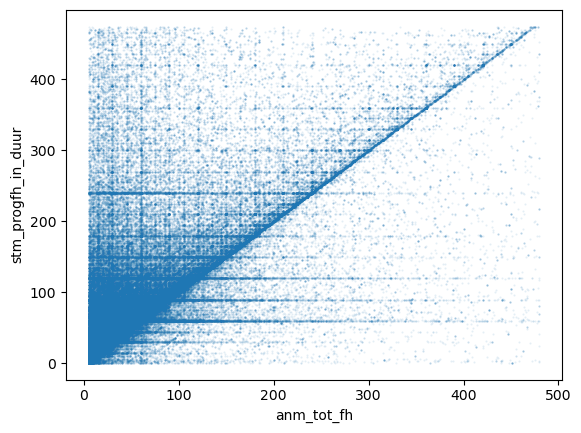

In [10]:
plt.scatter(dfprog['anm_tot_fh'], dfprog['stm_progfh_in_duur'], s=0.3, alpha=0.1)
plt.title('')
plt.xlabel('anm_tot_fh')
plt.ylabel('stm_progfh_in_duur')
# plt.plot(np.arange(0, 500), np.arange(0, 500), color='red')
# plt.show()

In [11]:
df.corr()['anm_tot_fh']

stm_mon_nr                   0.058842
stm_geo_mld_uit_functiepl    0.024191
stm_equipm_nr_mld            0.004377
stm_km_van_mld               0.000845
stm_km_tot_mld               0.023466
stm_prioriteit               0.065555
stm_geo_gst_uit_functiepl    0.027598
stm_equipm_nr_gst            0.011635
stm_km_van_gst               0.001569
stm_km_tot_gst               0.013892
stm_oorz_code                0.001064
stm_fh_status               -0.043950
stm_tao_telling_mutatie      0.026903
stm_contractgeb_mld         -0.031650
stm_contractgeb_gst         -0.031088
stm_arbeid                   0.713792
stm_progfh_in_duur          -0.042793
stm_progfh_gw_lwd_datum      0.040563
stm_progfh_gw_teller         0.101333
stm_fh_duur                  0.076504
stm_reactie_duur             0.021191
anm_tot_fh                   1.000000
Name: anm_tot_fh, dtype: float64

### stm_oorz_groep

In [12]:
df['stm_oorz_groep'].unique()

array(['TECHONV', '', 'ONR-RIB', 'ONR-DERD', 'WEER'], dtype=object)

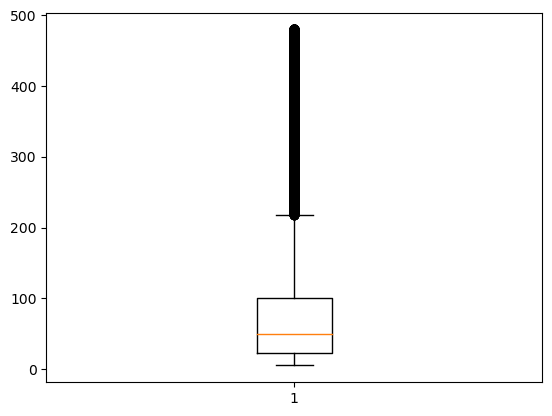

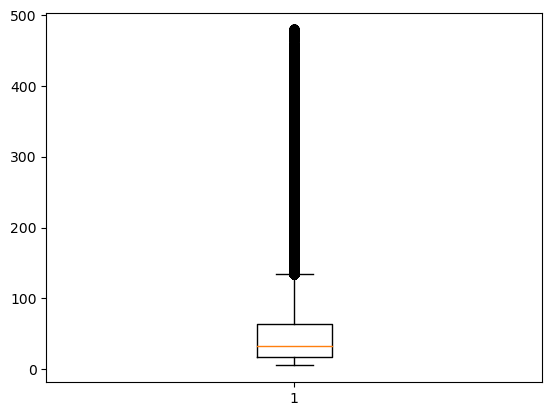

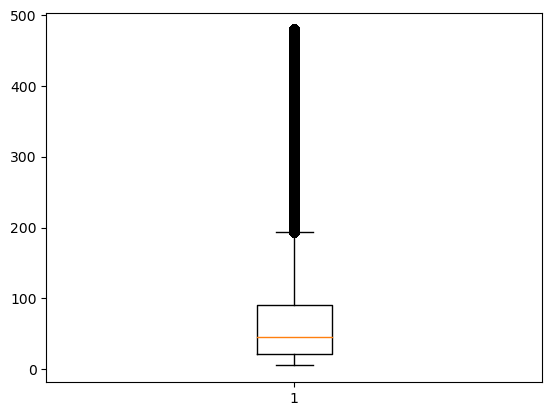

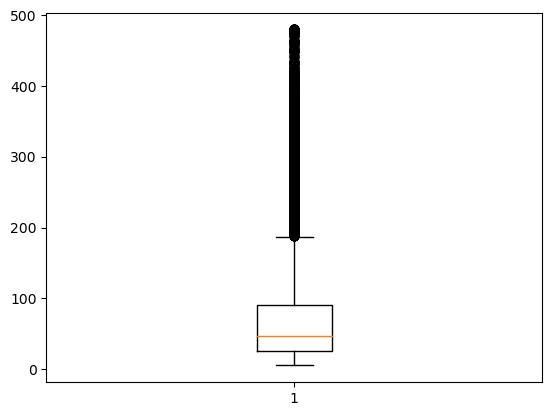

In [13]:
for value in ['ONR-RIB', 'ONR-DERD', 'TECHONV', 'WEER']:
    plt.boxplot(df[df.stm_oorz_groep == value]['anm_tot_fh'])
    plt.show()

In [14]:
for value in ['ONR-RIB', 'ONR-DERD', 'TECHONV', 'WEER']:
    print(df[df.stm_oorz_groep == value]['anm_tot_fh'].quantile([0.25, 0.5, 0.75]))

0.25     23.0
0.50     49.0
0.75    101.0
Name: anm_tot_fh, dtype: float64
0.25    17.0
0.50    33.0
0.75    64.0
Name: anm_tot_fh, dtype: float64
0.25    21.0
0.50    45.0
0.75    90.0
Name: anm_tot_fh, dtype: float64
0.25    25.0
0.50    46.0
0.75    90.0
Name: anm_tot_fh, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0cfdb65410>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0cfdb5eed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0cfdb6a110>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0cfdb54410>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0cfdb57e50>],
 'means': []}

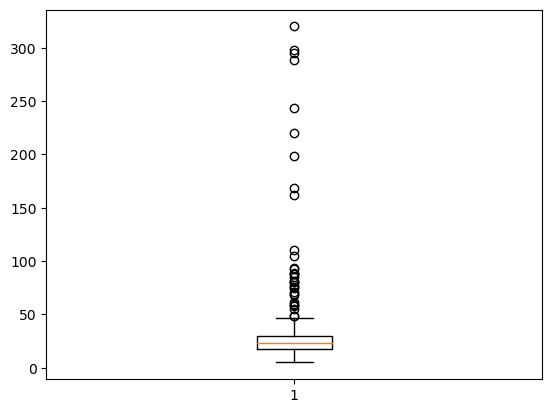

In [28]:
median_time = []
for value in df['stm_geo_mld'].unique():
    median_time.append(df[(df.stm_geo_mld == value) & (df.stm_oorz_code == 225)]['anm_tot_fh'].median())

median_time = [x for x in median_time if str(x) != 'nan']

plt.boxplot(median_time)

In [25]:
pd.options.display.max_rows = 50
with pd.option_context("display.max_rows", 1000):
    print(df['stm_oorz_code'].value_counts())

221.0    90363
218.0    65302
215.0    63459
135.0    27052
151.0    26301
133.0    24859
145.0    24229
294.0    23601
143.0    17046
213.0    14072
225.0    11032
140.0    10665
147.0    10154
203.0     8473
212.0     8037
298.0     7580
207.0     5859
219.0     5754
230.0     5348
146.0     5310
184.0     4749
241.0     4682
181.0     4542
183.0     4304
150.0     4284
226.0     4134
227.0     4033
182.0     3625
149.0     3536
209.0     3293
186.0     3107
228.0     2906
154.0     2796
214.0     2599
220.0     2195
187.0     2184
223.0     2133
222.0     2122
210.0     1970
144.0     1727
148.0     1646
299.0     1545
132.0     1507
211.0     1464
229.0     1431
240.0     1401
201.0     1091
242.0      911
204.0      703
208.0      701
250.0      669
185.0      540
234.0      514
224.0      485
188.0      468
141.0      423
142.0      311
235.0      235
231.0      197
134.0      146
239.0      130
189.0      128
206.0      105
131.0       97
130.0       66
202.0       52
136.0     

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0cfdc89dd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0cfdc83390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0cfdc8b410>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0cfdc7e910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0cfdc78a50>],
 'means': []}

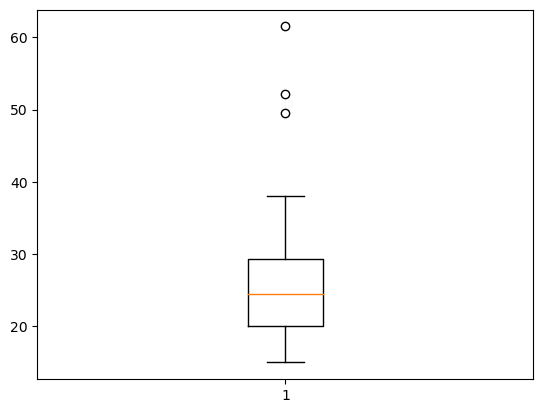

In [29]:
contract_time = []
for cont in df['stm_contractgeb_mld'].unique():
    contract_time.append(df[(df.stm_contractgeb_mld == cont) & (df.stm_oorz_code == 225)]['anm_tot_fh'].median())

contract_time = [x for x in contract_time if str(x) != 'nan']

plt.boxplot(contract_time)